<a href="https://colab.research.google.com/github/vithika-karan/Face-Emotion-Recognition/blob/main/Face_Emotion_Recognition_Vithika_Karan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install pandas numpy matplotlib seaborn pillow tensorflow keras scikit-learn opencv-python
#importing libraries
#dataprocessing
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import tensorflow
from tensorflow.keras.utils import to_categorical
import os
#model building
from keras.models import Sequential
from keras.layers import  Dense,Dropout,Activation,Flatten,BatchNormalization
from keras.layers import  Conv2D, MaxPooling2D, ZeroPadding2D
from tensorflow.keras.optimizers import Adam, SGD
from keras.callbacks import EarlyStopping
#metric
from sklearn.metrics import classification_report
#real time
import cv2
import warnings                                                                                
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [5]:
#reading csv
data = pd.read_csv('Project/data & resource/dataset/fer2013.zip', compression='zip')

In [6]:
#data shape
data.shape

(35887, 3)

In [7]:
#first three rows of the dataset
data.head(3)

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training


In [8]:
#check for null values
data.isnull().sum()

emotion    0
pixels     0
Usage      0
dtype: int64

There are no null values in the dataset.


In [9]:
#lets check the value counts in usage
data['Usage'].value_counts()

Usage
Training       28709
PublicTest      3589
PrivateTest     3589
Name: count, dtype: int64

In [10]:
#lets check the value counts in emotion column
data['emotion'].value_counts()

emotion
3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: count, dtype: int64

There are counts for seven emotions. Let's try to explore the images for these classes.

####**Exploratory Data Analysis**

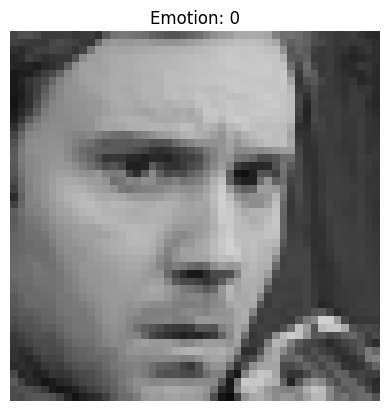

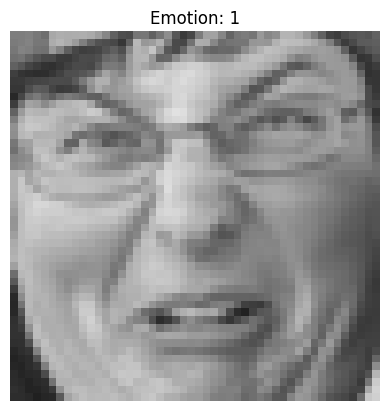

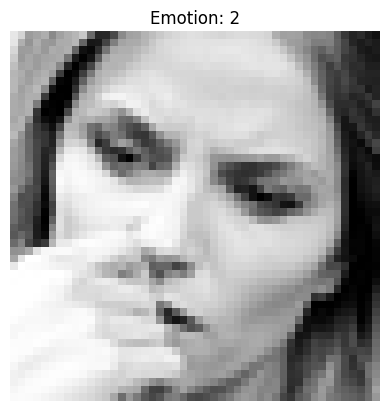

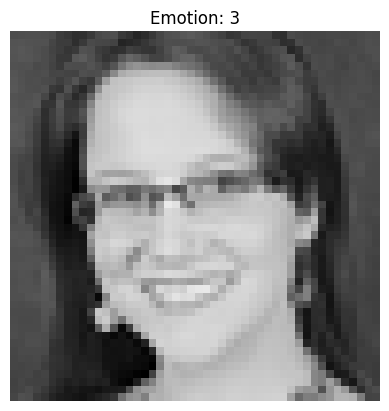

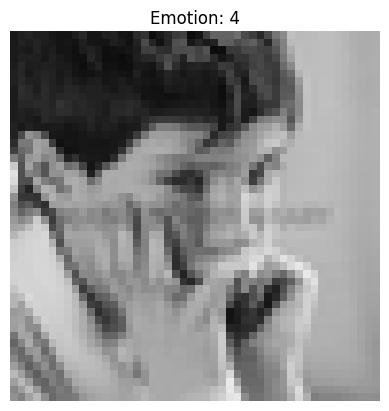

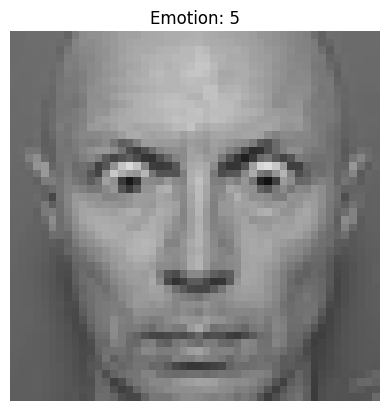

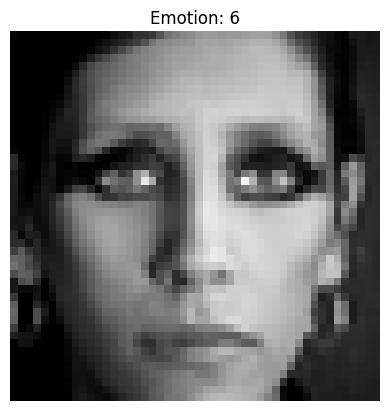

In [11]:
import numpy as np
import matplotlib.pyplot as plt

def show_img(df_row, pixel_string_col, class_col):
    ''' 
    This function takes in pixel data in the form of strings and the respective class of the picture.
    It preprocesses the data and returns an image matrix of 48x48 along with the class label, 
    which can be easily plotted to visualize the image.

    Parameters:
    df_row: A row of a dataframe with columns containing pixels as a string and the corresponding class label.
    pixel_string_col: Column name containing the pixels (dtype: string).
    class_col: Column name containing the class label (dtype: string).
    '''
    # Get the pixel data and class label from the dataframe row
    pixels = df_row[pixel_string_col]
    label = df_row[class_col]
    
    # Convert pixel string to a list of integers
    pic = np.array(pixels.split(), dtype=np.uint8)
    
    # Reshape the pixel list to a 48x48 array
    pic = pic.reshape(48, 48)
    
    # Optional: Convert grayscale to RGB by duplicating across channels
    image = np.zeros((48, 48, 3), dtype=np.uint8)
    image[:, :, 0] = pic  # Red channel
    image[:, :, 1] = pic  # Green channel
    image[:, :, 2] = pic  # Blue channel
    
    # Return the image (3-channel) and the label as a tuple
    return image, label

# Iterate over each emotion and plot the corresponding pixels
for emotion in range(0, 7):  # Assuming emotion labels range from 0 to 6
    picture = data[data['emotion'] == emotion].iloc[0]  # Select the first picture for each emotion
    picture_data = show_img(picture, 'pixels', 'emotion')
    
    # Display the image
    plt.imshow(picture_data[0])  # Show the RGB image
    plt.title(f"Emotion: {picture_data[1]}")
    plt.axis('off')  # Optional: Turn off the axis for better display
    plt.show() 

**Data Description**

The data consists of grayscale images of faces at a resolution of 48x48 pixels. The faces have been automatically registered such that they are more or less centred in each image and take up around the same amount of area.

The goal is to categorize each face into one of seven categories based on the emotion expressed in the facial expression (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral). There are 28,709 examples in the training set and 3,589 examples in the public test set.

Text(0.5, 1.0, 'Emotion Distribution')

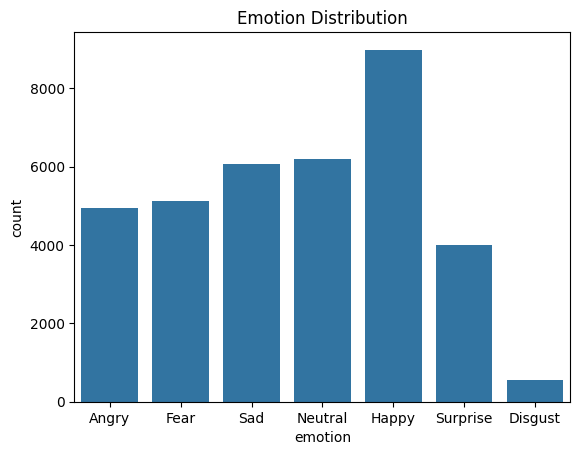

In [12]:
#plotting a bar graph of the emotions
#create dic of emotions
emo_dict = {0:'Angry', 1:'Disgust', 2:'Fear', 3:'Happy', 4:'Sad', 5:'Surprise',6:'Neutral'}
#creating a copy of data with actual categorial emotions
df1 = data.copy()
df1['emotion'] = df1['emotion'].map(emo_dict)
#plotting
sns.countplot(x=df1['emotion'])
plt.title('Emotion Distribution')

The number of happy pictures are the highest and disgusted pictures lowest in the dataset.

####**Data Pre-processing**



In [13]:
#splitting the data into train, validation and test set
train_data = data[data['Usage']=='Training']
val_data   = data[data['Usage']=='PublicTest']
test_data  = data[data['Usage']=='PrivateTest']
print("The shape of training set is: {}, \nThe shape of validation set is: {}, \nThe shape of test set is: {}".format(train_data.shape, val_data.shape, test_data.shape))

The shape of training set is: (28709, 3), 
The shape of validation set is: (3589, 3), 
The shape of test set is: (3589, 3)


In [14]:
#resetting index and dropping usage
for elem in [train_data,val_data,test_data]:
    elem.reset_index(drop=True, inplace= True)
    elem.drop('Usage',axis=1,inplace=True)

In [15]:
# Data preparation for test
def process_pixels(pixels):
    # If pixels are stored as a string, split them into a list of integers
    if isinstance(pixels, str):
        return [int(pixel) for pixel in pixels.split()]
    # If pixels are already a list, return it as is
    elif isinstance(pixels, list):
        return pixels
    else:
        raise ValueError("Unexpected format for pixels")

# Apply the processing function to the 'pixels' column
test_data['pixels'] = test_data['pixels'].apply(process_pixels)

# Reshape the test data and normalize the pixel values
X_test = np.array(test_data['pixels'].tolist(), dtype='float32').reshape(-1, 48, 48, 1) / 255.0 

# Convert emotion labels to one-hot encoded vectors
y_test = to_categorical(test_data['emotion'], num_classes=7)

The method flow from directory for Image Data Augmentation expects that images belonging to different classes are present in different folders but are inside the same parent folder. Let's create that.

In [16]:
#main data directory path
path = "Project/data & resource"

In [17]:
#import os

def create_dir(path, class_list):
    ''' 
    The function takes in the path and list of the classes to 
    create directories for different classes.
    
    Parameters:
    path: The path where train and validation directories need to be created.
    class_list: The list of labels in the dataset.
    ''' 
    # Create train and validation directories
    train_path = os.path.join(path, 'train')
    val_path = os.path.join(path, 'valid')
    
    try:
        os.mkdir(train_path)
        os.mkdir(val_path)
    except FileExistsError:
        print(f"Directory {train_path} or {val_path} already exists.")
    
    for data_path, cat in {train_path: 'train-', val_path: 'valid-'}.items():
        for label in class_list:
            label_dir = os.path.join(data_path, cat + str(label))
            try:
                os.mkdir(label_dir)
            except FileExistsError:
                print(f"Directory {label_dir} already exists.")

In [18]:
#creating directories
create_dir(path,[0,1,2,3,4,5,6])

Directory Project/data & resource\train or Project/data & resource\valid already exists.
Directory Project/data & resource\train\train-0 already exists.
Directory Project/data & resource\train\train-1 already exists.
Directory Project/data & resource\train\train-2 already exists.
Directory Project/data & resource\train\train-3 already exists.
Directory Project/data & resource\train\train-4 already exists.
Directory Project/data & resource\train\train-5 already exists.
Directory Project/data & resource\train\train-6 already exists.
Directory Project/data & resource\valid\valid-0 already exists.
Directory Project/data & resource\valid\valid-1 already exists.
Directory Project/data & resource\valid\valid-2 already exists.
Directory Project/data & resource\valid\valid-3 already exists.
Directory Project/data & resource\valid\valid-4 already exists.
Directory Project/data & resource\valid\valid-5 already exists.
Directory Project/data & resource\valid\valid-6 already exists.


In [19]:
train_path = "Project/data & resource/train"
val_path =  "Project/data & resource/valid"

In [20]:
#saving images
def save_imgs(df,df_path,pixel_col,class_col,class_list,prefix):
  '''This function takes in the dataframes and 
     creates images and saves images in directories.
     Parameters: 
     df: Dataframe that needs to be converted.
     df_path: Path to the directory (dtype-string)
              Example- If the training dataframe is fed, df_path should be the path
              to the train directory created.
     pixel_col: Name of the column containing pixels in string object
     class_col: Name of the column for data labels
     prefix: train- for training set, valid- for validation set  '''
  
  for i in range(len(df)):
      pixel_string = df[pixel_col][i]
      pixels = list(map(int, pixel_string.split()))
      
      matrix = np.array(pixels).reshape(48,48).astype(np.uint8)
      img = Image.fromarray(matrix)
      for label in class_list:
        if str(df[class_col][i]) in prefix + str(label):
            img.save(df_path +'/'+ prefix + str(label)+'/'+ prefix + str(label)+'-'+str(i)+'.png')
        else:
          continue


In [21]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def img_data_gen(train_path, val_path, target_size, batch_size, color_mode, class_mode):
    ''' 
    This function generates augmented training data and rescales validation images, given the paths.

    Parameters:
    train_path: Path to the training directory of images.
    val_path: Path to the validation directory of images.
    target_size: Target size for images (example: (48, 48)).
    batch_size: Number of images per batch.
    color_mode: Color mode, e.g., 'grayscale' or 'rgb'.
    class_mode: Classification mode, e.g., 'binary' or 'categorical'.
    
    Returns:
    train_generator: Generator for the training set.
    val_generator: Generator for the validation set.
    '''
    
    # Image data generator for training with augmentation
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=10,
        horizontal_flip=True,
        width_shift_range=0.1,
        height_shift_range=0.1,
        fill_mode='nearest'
    )
    
    # Image data generator for validation (no augmentation)
    val_datagen = ImageDataGenerator(rescale=1./255)
    
    # Training data generator
    train_generator = train_datagen.flow_from_directory(
        train_path,
        target_size=target_size,
        batch_size=batch_size,
        color_mode=color_mode,
        seed=42,
        shuffle=True,
        class_mode=class_mode
    )
    
    # Validation data generator
    val_generator = val_datagen.flow_from_directory(
        val_path,
        target_size=target_size,
        batch_size=batch_size,
        color_mode=color_mode,
        seed=42,
        shuffle=True,  # You can set shuffle=False if you want consistent validation
        class_mode=class_mode
    )
    
    return train_generator, val_generator

In [23]:
#train images
save_imgs(train_data,train_path,'pixels','emotion',[0,1,2,3,4,5,6],'train-')
#validation images
save_imgs(val_data,val_path,'pixels','emotion',[0,1,2,3,4,5,6],'valid-')

In [24]:
#image generators
train_gen, val_gen = img_data_gen(train_path,val_path,target_size=(48,48),batch_size=64,color_mode='grayscale',class_mode='categorical')

Found 28709 images belonging to 7 classes.
Found 3589 images belonging to 7 classes.


####**Model Building**

In [26]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Convolution2D, BatchNormalization, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam

model = Sequential()
num_classes = 7

# 1st Block
model.add(Convolution2D(64, kernel_size=3, activation='relu', padding='same', input_shape=(48, 48, 1)))
model.add(BatchNormalization())
model.add(Convolution2D(64, kernel_size=3, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# 2nd Block
model.add(Convolution2D(128, kernel_size=3, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Convolution2D(128, kernel_size=3, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Convolution2D(128, kernel_size=3, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

# 3rd Block
model.add(Convolution2D(256, kernel_size=3, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Convolution2D(256, kernel_size=3, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Convolution2D(256, kernel_size=3, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

# 4th Block
model.add(Convolution2D(256, kernel_size=3, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Convolution2D(256, kernel_size=3, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Convolution2D(256, kernel_size=3, activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

# Flatten and Fully Connected Layers
model.add(Flatten())

# Optional Dense Layers
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(num_classes, activation='softmax'))

# Summary of the model
model.summary()

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_11 (Conv2D)                   │ (None, 48, 48, 64)          │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 48, 48, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 48, 48, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_12               │ (None, 48, 48, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 24, 24, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_13 (Conv2D)                   │ (None, 24, 24, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_13               │ (None, 24, 24, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_14 (Conv2D)                   │ (None, 24, 24, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_14               │ (None, 24, 24, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_15 (Conv2D)                   │ (None, 24, 24, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_15               │ (None, 24, 24, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 12, 12, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_16 (Conv2D)                   │ (None, 12, 12, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_16               │ (None, 12, 12, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_17 (Conv2D)                   │ (None, 12, 12, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_17               │ (None, 12, 12, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │              

 Total params: 4,844,103 (18.48 MB)

 Trainable params: 4,840,007 (18.46 MB)

 Non-trainable params: 4,096 (16.00 KB)

In [27]:
#model compiling
optimizer = Adam(learning_rate=0.0001, decay=1e-6)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [28]:
#training
earlystop = EarlyStopping(monitor='val_loss',min_delta=0,patience = 10, verbose=1,restore_best_weights=True)

epochs = 40
#fitting
history=model.fit(train_gen,
                steps_per_epoch=len(train_data)//64,
                epochs=epochs,
                batch_size= 32,
                callbacks=earlystop,
                verbose= 1,
                validation_data=val_gen,
                validation_steps=len(val_data)//64)

Epoch 1/40
448/448 ━━━━━━━━━━━━━━━━━━━━ 1528s 3s/step - accuracy: 0.1964 - loss: 2.5658 - val_accuracy: 0.2215 - val_loss: 1.8468
Epoch 2/40
448/448 ━━━━━━━━━━━━━━━━━━━━ 3s 495us/step - accuracy: 0.2500 - loss: 1.8236 - val_accuracy: 0.2000 - val_loss: 1.5871
Epoch 3/40
448/448 ━━━━━━━━━━━━━━━━━━━━ 1288s 3s/step - accuracy: 0.2344 - loss: 1.8205 - val_accuracy: 0.2634 - val_loss: 1.7924
Epoch 4/40
448/448 ━━━━━━━━━━━━━━━━━━━━ 3s 221us/step - accuracy: 0.1719 - loss: 1.9128 - val_accuracy: 0.2000 - val_loss: 2.2499
Epoch 5/40
448/448 ━━━━━━━━━━━━━━━━━━━━ 1265s 3s/step - accuracy: 0.2559 - loss: 1.7897 - val_accuracy: 0.3050 - val_loss: 1.6980
Epoch 6/40
448/448 ━━━━━━━━━━━━━━━━━━━━ 3s 229us/step - accuracy: 0.2188 - loss: 1.7289 - val_accuracy: 0.2000 - val_loss: 1.6660
Epoch 7/40
448/448 ━━━━━━━━━━━━━━━━━━━━ 1270s 3s/step - accuracy: 0.2933 - loss: 1.7429 - val_accuracy: 0.3064 - val_loss: 1.8483
Epoch 8/40
448/448 ━━━━━━━━━━━━━━━━━━━━ 3s 230us/step - accuracy: 0.3594 - loss: 1.6105 - 

Restored the best model weights, which was for the epoch 45 with the following result:
* loss: 0.7075 - accuracy: 0.7381 - val_loss: 0.9825 - val_accuracy: 0.6643

####**Model Evaluation**

In [29]:

#saving the history of the model in dataframe  
model_df = pd.DataFrame(model.history.history)


Text(0.5, 1.0, 'Loss Plots for Training and Validation Sets')

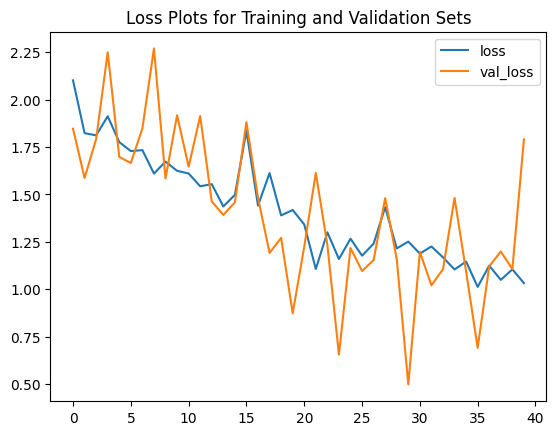

In [30]:
#Plotting Loss 
model_df[['loss','val_loss']].plot()
plt.title("Loss Plots for Training and Validation Sets")

Text(0.5, 1.0, 'Accuracy Plots for Training and Validation Sets')

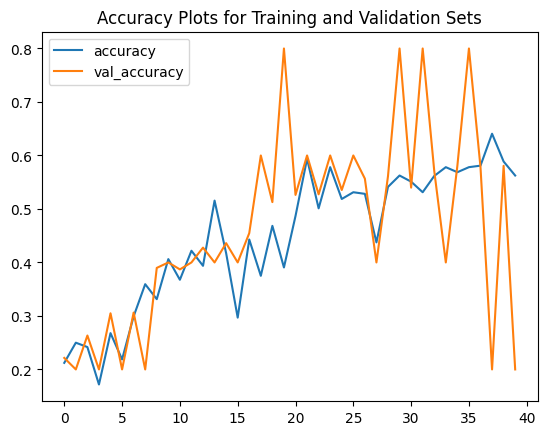

In [31]:
#Plotting accuracy 
model_df[['accuracy','val_accuracy']].plot()
plt.title("Accuracy Plots for Training and Validation Sets")

**Predictions on Test Data**

In [32]:
#test predictions 
true_y  = np.argmax(y_test,axis=1)
pred_y = np.argmax(model.predict(X_test),axis=1)
print(classification_report(true_y,pred_y))

113/113 ━━━━━━━━━━━━━━━━━━━━ 66s 584ms/step
              precision    recall  f1-score   support

           0       0.54      0.37      0.44       491
           1       0.45      0.09      0.15        55
           2       0.42      0.17      0.24       528
           3       0.73      0.87      0.79       879
           4       0.41      0.49      0.45       594
           5       0.68      0.72      0.70       416
           6       0.48      0.65      0.55       626

    accuracy                           0.57      3589
   macro avg       0.53      0.48      0.48      3589
weighted avg       0.55      0.57      0.54      3589



The predictions on the test set are pretty great with accuracy of 0.68 which implies generalization of the model is good as compared to the training results.


####**Save the Model**

In [39]:
#saving model 
model.save(path+'Emotion Detection Model/emotion_detection.keras')

####**Real Time Emotion Detection**

The following code for real time emotion detection was run on local device and the results are attached along with it.

In [40]:
#load model
model = tensorflow.keras.models.load_model(path+'Emotion Detection Model/emotion_detection.keras')

In [41]:
face_haar_cascade = cv2.CascadeClassifier(path+'haarcascade_frontalface_default.xml')

In [ ]:
import cv2
import numpy as np
import tensorflow.keras
import tensorflow as tf

# Load the pre-trained model (adjust the path if needed)
model = tf.keras.models.load_model('Project/data & resourceEmotion Detection Model/emotion_detection.keras')

# Load the Haar Cascade XML file for face detection
face_haar_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Start video capture
cap = cv2.VideoCapture(0)

if not cap.isOpened():
    print("Error: Could not open video capture.")
else:
    while cap.isOpened():
        ret, img = cap.read()
        if not ret:
            print("Error: Could not read frame.")
            break
        
        height, width, channel = img.shape
        
        # Create the heading section at the top of the frame
        sub_img = img[0:int(height / 6), 0:int(width)]
        heading = np.ones(sub_img.shape, dtype=np.uint8) * 0
        result = cv2.addWeighted(sub_img, 0.82, heading, 0.18, 0)
        
        # Add the heading text "Emotion Detection"
        font = cv2.FONT_HERSHEY_SIMPLEX
        font_scale = 0.8
        font_thickness = 2
        label_color = (0, 255, 0)
        label = "Emotion Detection"
        label_dimension = cv2.getTextSize(label, font, font_scale, font_thickness)[0]
        textX = int((result.shape[1] - label_dimension[0]) / 2)
        textY = int((result.shape[0] + label_dimension[1]) / 2)
        cv2.putText(result, label, (textX, textY), font, font_scale, (0, 0, 0), font_thickness)
        
        # Convert the image to grayscale for face detection
        gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        # Detect faces in the frame
        faces = face_haar_cascade.detectMultiScale(gray_image, scaleFactor=1.1, minNeighbors=5)
        
        try:
            # Loop over the detected faces and make emotion predictions
            for (x, y, w, h) in faces:
                # Draw rectangle around the face
                cv2.rectangle(img, (x, y), (x + w, y + h), (0, 0, 255), 2)
                
                # Extract region of interest (ROI) for emotion detection
                roi_gray = gray_image[y:y + h, x:x + w]
                roi_gray = cv2.resize(roi_gray, (48, 48))
                image_pixels = tf.keras.preprocessing.image.img_to_array(roi_gray)
                image_pixels = np.expand_dims(image_pixels, axis=0)
                image_pixels /= 255  # Normalize pixel values
                
                # Predict the emotion
                predictions = model.predict(image_pixels)
                max_index = np.argmax(predictions[0])
                
                # Map the prediction to an emotion label
                emotion_labels = ['Anger', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprised', 'Neutral']
                emotion_prediction = emotion_labels[max_index]
                
                # Display the predicted emotion on the frame
                cv2.putText(img, emotion_prediction, (x, y - 10), font, 0.9, label_color, 2)
        
        except Exception as e:
            print(f"Error during prediction: {e}")
        
        # Overlay the heading on the frame
        img[0:int(height / 6), 0:int(width)] = result
        
        # Show the frame with detected emotion
        cv2.imshow('Emotion Detection', img)
        
        # Press 'q' to exit the video feed
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    
    # Release the video capture and destroy all windows
    cap.release()
    cv2.destroyAllWindows(

The model pretty accurately detected all the emotions beside disgust. The training daata for the emotion class - disgust were pretty low as compared to others. Here are the results: